# **NumPy Image Procesing**

In [1]:
import os

In [2]:
num_threads = "1"
os.environ["OMP_NUM_THREADS"] = num_threads
os.environ["OPENBLAS_NUM_THREADS"] = num_threads
os.environ["MKL_NUM_THREADS"] = num_threads
os.environ["VECLIB_MAXIMUM_THREADS"] = num_threads
os.environ["NUMEXPR_NUM_THREADS"] = num_threads

In [3]:
print(os.environ.get("OMP_NUM_THREADS"))

8


In [4]:
print(os.environ.get("OPENBLAS_NUM_THREADS"))

1


In [5]:
print(os.environ.get("MKL_NUM_THREADS"))

8


In [6]:
print(os.environ.get("VECLIB_MAXIMUM_THREADS") )

8


In [7]:
print(os.environ.get("NUMEXPR_NUM_THREADS"))

8


In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import cv2
import time
%matplotlib inline

In [2]:
# save pickle
def save_pickle(filename, obj):
    with open(str(filename), 'wb') as f:
        pickle.dump(obj, f)
    print("Object saved")
        
# load pickle
def load_pickle(filename):
    with open(str(filename), 'rb') as f:
        obj = pickle.load(f)
    print("Object loaded")
    return obj

In [193]:
#save_pickle('tensor_collection_new.pkl', tensor_collection)
tensor_collection = load_pickle('tensor_collection_new.pkl')

Object loaded


In [12]:
def calc_grayscale(layer_imgs, norm_val, npad, n_img_max=64, row_break_after=8):
    """
    Calculates normalized matrices in a list of 2D arrays and maps them to grayscale
    Input: NumPy array with 3 dimensions (num_pic, width, height)
    Output: modified NumPy array with same 3 dimensions
    """
    
    if layer_imgs.shape[0] <= 64:
        n = layer_imgs.shape[0]
    else:
        n = n_img_max
    
    # normalize images
    for i in range(n):
        #img = test_map[i,:,:]
        img = layer_imgs[i]
        #print("TEST")
        v_min = np.asarray([img.min()], dtype=np.float32)
        v_max = np.asarray([img.max()], dtype=np.float32)
        img -= v_min
        img /= (v_max - v_min)
        img *= norm_val
    
    # pad batch
    #layer_imgs = np.pad(layer_imgs, pad_width=npad, mode='constant', constant_values=255)

    # pad and concatenate
    #padded_data = np.pad(data, pad_width=npad, mode='constant', constant_values=255)
    rows = []
    for i in range(0, n, row_break_after):
        #concatenate arrays along "w" axis
        row = np.concatenate(layer_imgs[i:i+row_break_after], axis=1)
        rows.append(row)
    
    #concatenate arrays along "h" axis
    return np.concatenate(rows, axis=0)


def calc_grayscale_dataset(data_dict, layer_nums=[]):
    """
    For whole data set as PyTorch Yolo tensor:
    Calculates normalized matrices in a list of 2D arrays and maps them to grayscale
    
    Input: User-defined tensor collection library added to the Yolo Model as attribute
    Output: Dictionary with layer number as key and corresponding normalized feature maps
    """
    
    ret_dict = {}
    norm_val = np.asarray([255], dtype=np.float32) # normalization value of 255 (grayscale --> white)
    padding_width = 5
    npad = ((0,0), (padding_width, padding_width), (padding_width, padding_width))

    if layer_nums:
        keys = layer_nums
    else:
        keys = data_dict.keys()

    for key in keys:
        # get PyTorch Yolo tensor with 3 dimensions (num_pics, width, height)
        # transform to NumPy array
        ret_dict[key] = calc_grayscale(data_dict[key][0].detach().numpy(), norm_val, npad)
        
    
    return ret_dict

In [13]:
layer_nums = []
test = tensor_collection

In [14]:
%%timeit
ret = calc_grayscale_dataset(tensor_collection)

50.1 ms ± 402 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


(-0.5, 5199.5, 1831.5, -0.5)

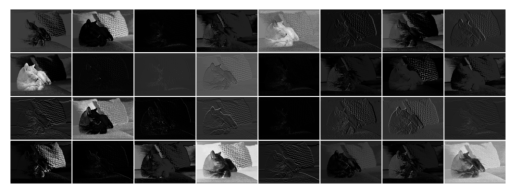

In [12]:
plt.imshow(ret[0], cmap='gray')
plt.axis('off')

## **Improved Functions**

In [194]:
def calc_feature_maps_grid(layer_imgs, norm_val, npad_inner, layer_id=None, n_img_max=64, row_break_after=8):
    """
    - calculates normalized matrices to a maximum number of 64 elements and maps them to grayscale
    - puts elements in a grid
    Input: 
        - layer_imgs:      NumPy array with 3 dimensions (num_pic, width, height), derived from Yolo Model tensor collection
        - norm_val:        normalization value (max value from image processing 255) as NumPy array
        - npad_inner:      padding values for each feature map
        - layer_id:        number of layer which is processed
        - n_img_max:       maximum amount of feature maps which are considered, all maps with index >= n_img_max are negated
        - row_break_after: number of columns for image grid which is to be built
    Output: NumPy array - full normalized and resized image grid with all chosen feature maps and additional layer information
    """
    t0 = time.time()
    if layer_imgs.shape[0] <= n_img_max:
        n = layer_imgs.shape[0]
    else:
        n = n_img_max
    
    # normalize images
    for i in range(n):
        #img = test_map[i,:,:]
        img = layer_imgs[i]
        #print("TEST")
        v_min = np.asarray([img.min()], dtype=np.float32)
        v_max = np.asarray([img.max()], dtype=np.float32)
        img -= v_min
        img /= (v_max - v_min)
        img *= norm_val
    
    t1 = time.time()
    print(f"Batch processing lasted: {(t1-t0) * 1000} ms")
    # pad single feature maps for better appearance
    layer_imgs = np.pad(layer_imgs, pad_width=npad_inner, mode='constant', constant_values=255.0)
    
    # https://stackoverflow.com/questions/42040747/more-idiomatic-way-to-display-images-in-a-grid-with-numpy
    nindex, height, width = layer_imgs[:n,:,:].shape
    nrows = n // row_break_after
    img_grid = (layer_imgs[:n,:,:].reshape(nrows, row_break_after, height, width)
              .swapaxes(1,2)
              .reshape(height*nrows, width*row_break_after))
    
    # convert data type
    img_grid = img_grid.astype(np.uint8)
    
    # resize image
    target_width = 400
    scale_percent = float(target_width / img_grid.shape[1])
    target_height = int(img_grid.shape[0] * scale_percent)
    dim = (target_width, target_height)
    if scale_percent > 1.0: # upsampling
        result = cv2.resize(img_grid, dim, interpolation=cv2.INTER_CUBIC)
    else: # downsampling
        result = cv2.resize(img_grid, dim, interpolation=cv2.INTER_AREA)
    
    # create new filled array of desired size
    size_x = 450
    size_y = 450
    use_fixed_bound_x = True
    img_canvas = np.full((size_x, size_y), 255, dtype=np.uint8)
    # place smaller image in the greater canvas
    # shifting values s_x, s_y
    if use_fixed_bound_x: # same distance from above
        s_x = 60
    else: # center vertically
        s_x = int((size_x - result.shape[0]) / 2)
    s_y = int((size_y - result.shape[1]) / 2) # center horizontally
    img_canvas[s_x:(s_x+result.shape[0]),s_y:(s_y+result.shape[1])] = result[:]
    
    # add text label with layer number
    layer_name = f"Layer {layer_id+1} ({n} out of {layer_imgs.shape[0]} outputs)"
    cv2.putText(img_canvas, layer_name, (15, 40), 0, 0.65, [0, 0, 0], thickness=2, lineType=cv2.LINE_AA)
    
    
    return img_canvas


def calc_feature_maps_dataset(data_dict, layer_nums=[], ncol=4):
    """
    For whole data set as dictionary with PyTorch Yolo tensors:
        --> func call calc_feature_maps_grid:
            - calculates normalized matrices to a maximum number of 64 elements and maps them to grayscale
            - puts elements in a grid
    - order feature map grids as one single grid in a large picture, ready to be displayed by any viewer 
      which accepts NumPy arrays
    
    Input: User-defined tensor collection dictionary added to the Yolo Model as attribute
        - data_dict:    tensor collection from Yolo Model
        - layer_nums:   used to pre-filter layers for which calculation shall take place
        - ncol:         number of columns in final output image
    Output: Single image with provided feature maps visualized
    """
    
    ret_dict = {}
    norm_val = np.asarray([255], dtype=np.float32) # normalization value of 255 (grayscale --> white)
    padding_width_inner = 5
    npad_inner = ((0,0), (padding_width_inner, padding_width_inner), (padding_width_inner, padding_width_inner))


    if layer_nums:
        keys = layer_nums
    else:
        keys = data_dict.keys()
    
    img_grid_list = []
    for key in keys:
        # get PyTorch Yolo tensor with 3 dimensions (num_pics, width, height)
        # transform to NumPy array
        img_grid_list.append(calc_feature_maps_grid(data_dict[key][0].detach().numpy(), norm_val, npad_inner, layer_id=key))
        
    img_grid_array = np.stack(img_grid_list)
    nindex, height, width = img_grid_array.shape
    nrows = nindex // ncol
    img_grid = (img_grid_array.reshape(nrows, ncol, height, width)
              .swapaxes(1,2)
              .reshape(height*nrows, width*ncol))
    
    return img_grid

In [195]:
test = tensor_collection

In [197]:
#%%timeit -n 20
ret = calc_feature_maps_dataset(test)

Batch processing lasted: 5.001068115234375 ms
Batch processing lasted: 2.0008087158203125 ms
Batch processing lasted: 2.001047134399414 ms
Batch processing lasted: 1.0004043579101562 ms
Batch processing lasted: 1.0001659393310547 ms
Batch processing lasted: 0.0 ms
Batch processing lasted: 0.0 ms
Batch processing lasted: 0.9996891021728516 ms


In [9]:
%%timeit -n 20
ret = calc_feature_maps_dataset(test)

89.6 ms ± 535 µs per loop (mean ± std. dev. of 7 runs, 20 loops each)


In [9]:
import psutil

In [10]:
p = psutil.Process()

In [15]:
p.cpu_affinity([0])

In [16]:
p.cpu_affinity()

[0]

In [17]:
np.show_config()

blas_armpl_info:
  NOT AVAILABLE
blas_mkl_info:
    libraries = ['mkl_rt']
    library_dirs = ['C:/Users/flori/anaconda3/envs/CNN_Vis\\Library\\lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = ['C:/Users/flori/anaconda3/envs/CNN_Vis\\Library\\include']
blas_opt_info:
    libraries = ['mkl_rt']
    library_dirs = ['C:/Users/flori/anaconda3/envs/CNN_Vis\\Library\\lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = ['C:/Users/flori/anaconda3/envs/CNN_Vis\\Library\\include']
lapack_armpl_info:
  NOT AVAILABLE
lapack_mkl_info:
    libraries = ['mkl_rt']
    library_dirs = ['C:/Users/flori/anaconda3/envs/CNN_Vis\\Library\\lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = ['C:/Users/flori/anaconda3/envs/CNN_Vis\\Library\\include']
lapack_opt_info:
    libraries = ['mkl_rt']
    library_dirs = ['C:/Users/flori/anaconda3/envs/CNN_Vis\\Library\\lib']
    define_macros = [('SC

In [863]:
arr_list = []
for key in ret.keys():
    print(f"size of image = {ret[key].shape}")
    arr_list.append(ret[key])

size of image = (450, 450)
size of image = (450, 450)
size of image = (450, 450)
size of image = (450, 450)
size of image = (450, 450)
size of image = (450, 450)
size of image = (450, 450)
size of image = (450, 450)


In [864]:
arr_dim = np.stack(arr_list)

In [865]:
arr_dim.shape

(8, 450, 450)

In [866]:
ncol = 4
nindex, height, width = arr_dim.shape
nrows = nindex // ncol
img_grid = (arr_dim.reshape(nrows, ncol, height, width)
          .swapaxes(1,2)
          .reshape(height*nrows, width*ncol))

In [867]:
img_grid.shape

(900, 1800)

In [874]:
cv2.imshow("Window", ret)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [694]:
arr = ret[0].copy()

In [695]:
arr.shape

(600, 700)

In [650]:
# create new filled array of desired size
size_x = 600
size_y = 800
arr_canvas = np.full((size_x, size_y), 200, dtype=np.uint8)

In [651]:
# place smaller image in the middle of the greater canvas
# shifting values s_x, s_y
s_x = int((size_x - arr.shape[0]) / 2)
s_y = int((size_y - arr.shape[1]) / 2)

In [652]:
arr_canvas[s_x:(s_x+arr.shape[0]),s_y:(s_y+arr.shape[1])] = arr[:]

In [772]:
ret[99].min()

0

In [773]:
ret[99].shape

(600, 700)

In [808]:
test_arr = ret[99]

In [810]:
cv2.imshow("Window", test_arr)
cv2.waitKey(0)
cv2.destroyAllWindows()

(-0.5, 699.5, 599.5, -0.5)

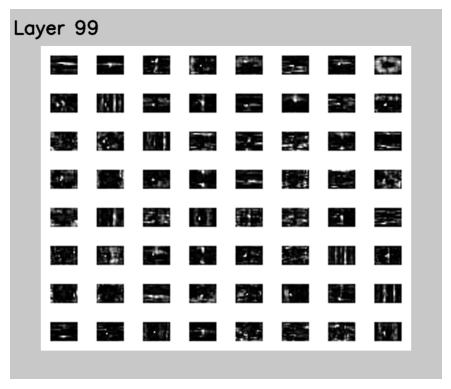

In [766]:
plt.imshow(ret[99], cmap='gray')
plt.axis('off')

In [738]:
ret[99].min()

-57.821335

In [466]:
arr = ret[1]

In [316]:
arr.shape

(32, 448, 640)

In [355]:
n, h, w = arr.shape

In [358]:
num_cols = 8

In [359]:
num_rows = n // num_cols
num_rows

4

In [599]:
arr = np.array([[0,2,3],[3,3,3],[3,3,3]])

In [600]:
arr.shape

(3, 3)

In [601]:
arr2 = np.array([[0,2,3],[3,3,3]])

In [602]:
arr2.shape

(2, 3)

In [603]:
ret = np.stack([arr,arr2])

ValueError: all input arrays must have the same shape

In [593]:
list_arr = np.empty((8,))

In [598]:
list_arr[0] = arr

ValueError: setting an array element with a sequence.

In [342]:
img_width = row_break_after * w
img_width

5120

In [343]:
img_height = num_row * h
img_height

1792

In [388]:
def gallery(array, ncols=8):
    nindex, height, width = arr.shape
    nrows = nindex // ncols
    result = (array.reshape(nrows, ncols, height, width)
              .swapaxes(1,2)
              .reshape(height*nrows, width*ncols))
    return result

In [389]:
arr2 = arr.copy()

In [390]:
res = gallery(arr2)

In [391]:
res.shape

(1792, 2560)

(-0.5, 2559.5, 1791.5, -0.5)

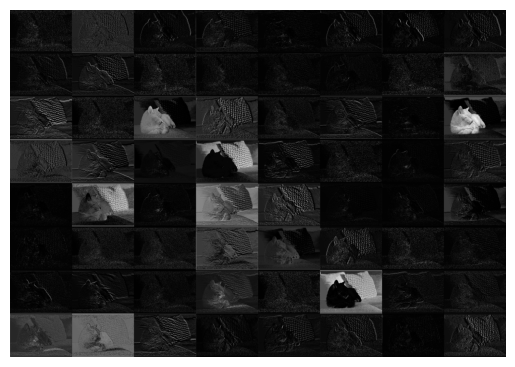

In [392]:
plt.imshow(res, cmap='gray')
plt.axis('off')

---

# **PyTorch**

In [13]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import cv2
import torch
%matplotlib inline

In [14]:
# save pickle
def save_pickle(filename, obj):
    with open(str(filename), 'wb') as f:
        pickle.dump(obj, f)
    print("Object saved")
        
# load pickle
def load_pickle(filename):
    with open(str(filename), 'rb') as f:
        obj = pickle.load(f)
    print("Object loaded")
    return obj

In [15]:
#save_pickle('tensor_collection_new.pkl', tensor_collection)
tensor_collection = load_pickle('tensor_collection_new.pkl')

Object loaded


In [25]:
import multiprocessing as mp
import time

In [5]:
mgr = mp.Manager()
queue = mgr.Queue()
#queue = mp.Queue()

In [6]:
tensor_collection[0].is_shared()

False

In [7]:
%%timeit -n 1000
queue.put(tensor_collection)
#ret = queue.get()

The slowest run took 4.77 times longer than the fastest. This could mean that an intermediate result is being cached.
355 µs ± 298 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [21]:
#save_pickle('tensor_collection_new.pkl', tensor_collection)
#tensor_collection = load_pickle('tensor_collection_new.pkl')
tensor_collection = load_pickle('tensor_collection_test_0.pkl')
#tensor_collection[0].is_shared()

Object loaded


In [22]:
# move tensors to GPU with gradient
device = torch.device('cuda')
tensor_list = []
for key, tensor in tensor_collection.items():
    tensor_collection[key] = tensor.to(device)
    print(f"Max val {tensor_collection[key].max()}")
    print(f"Min val {tensor_collection[key].min()}")
    print(f"Size {tensor_collection[key].size()}")
    tensor_list.append(tensor.to(device))

Max val 255.0
Min val 0.0
Size torch.Size([1576, 5200])
Max val 255.0
Min val 0.0
Size torch.Size([1616, 2640])
Max val 255.0
Min val 0.0
Size torch.Size([1616, 2640])
Max val 255.0
Min val 0.0
Size torch.Size([464, 720])
Max val 255.0
Min val 0.0
Size torch.Size([272, 400])
Max val 255.0
Min val 0.0
Size torch.Size([272, 400])
Max val 255.0
Min val 0.0
Size torch.Size([176, 240])
Max val 255.0
Min val 0.0
Size torch.Size([176, 240])


In [23]:
T1 = tensor_list[0]
T2 = tensor_list[1]
T3 = tensor_list[3]

In [36]:
T1

tensor([[255., 255., 255.,  ..., 255., 255., 255.],
        [255., 255., 255.,  ..., 255., 255., 255.],
        [255., 255., 255.,  ..., 255., 255., 255.],
        ...,
        [255., 255., 255.,  ..., 255., 255., 255.],
        [255., 255., 255.,  ..., 255., 255., 255.],
        [255., 255., 255.,  ..., 255., 255., 255.]], device='cuda:0',
       dtype=torch.float16)

In [25]:
import io
import time

In [35]:
%%timeit -n 20
buff = io.BytesIO()
torch.save(T1, buff)
#buff.seek(0)
#ret = torch.load(buff)

18 ms ± 481 µs per loop (mean ± std. dev. of 7 runs, 20 loops each)


In [51]:
torch.cuda.synchronize()
s = time.time()
t = T2.clone().cpu()
torch.cuda.synchronize()
e = time.time()
print(f"{(e-s)*1000}")

5.001306533813477


In [27]:
torch.save(T1, buff)

In [28]:
buff.seek(0)

0

In [29]:
ret = torch.load(buff)

In [30]:
ret

tensor([[255., 255., 255.,  ..., 255., 255., 255.],
        [255., 255., 255.,  ..., 255., 255., 255.],
        [255., 255., 255.,  ..., 255., 255., 255.],
        ...,
        [255., 255., 255.,  ..., 255., 255., 255.],
        [255., 255., 255.,  ..., 255., 255., 255.],
        [255., 255., 255.,  ..., 255., 255., 255.]], device='cuda:0',
       dtype=torch.float16)

In [28]:
tensor_collection[0].is_shared()

True

In [30]:
T3.size()

torch.Size([1, 512, 56, 80])

In [13]:
#import torch.multiprocessing as mp
import multiprocessing as mp

In [14]:
mgr = mp.Manager()
queue = mgr.Queue()
#queue = mp.Queue()

In [15]:
%%timeit -n 1000
queue.put(T1)
#ret = queue.get()

The slowest run took 9.52 times longer than the fastest. This could mean that an intermediate result is being cached.
334 µs ± 444 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


## **Normalization**

In [39]:
dim, batch, height, width = T1.size()
batch = batch if batch <= 64 else 64 # process only max number of layers

In [40]:
batch

32

In [33]:
#AA = T1[0].detach().clone()
AA = T3[0,:n].detach().clone()
#AA = T2[0].clone()
norm_val = torch.tensor([255], dtype=torch.float32, device=device)

In [34]:
AA.size()

torch.Size([64, 56, 80])

In [35]:
torch.cuda.synchronize()
t0 = time.time()
batch, height, width = AA.size()
A = AA.view(batch, -1)
A -= A.min(1, keepdim=True)[0]
A /= A.max(1, keepdim=True)[0]
A *= norm_val
A = A.view(batch, height, width)
torch.cuda.synchronize()
t1 = time.time()
print(f"Batch processing lasted: {(t1-t0) * 1000} ms")

Batch processing lasted: 8.001327514648438 ms


In [36]:
A.size()

torch.Size([64, 56, 80])

In [221]:
import torch.nn.functional as F

In [222]:
padding_width_inner = 5
# torch padding from last dim --> first dim
npad_inner = (padding_width_inner, padding_width_inner, padding_width_inner, padding_width_inner)

In [228]:
layer_imgs = F.pad(A, pad=npad_inner, mode='constant', value=255.0)

In [229]:
layer_imgs.size()

torch.Size([32, 458, 650])

In [230]:
n = 32
row_break_after = 8
# https://stackoverflow.com/questions/42040747/more-idiomatic-way-to-display-images-in-a-grid-with-numpy
nindex, height, width = layer_imgs[:n,:,:].size()
nrows = n // row_break_after
img_grid = (layer_imgs[:n,:,:].reshape(nrows, row_break_after, height, width)
          .swapaxes(1,2)
          .reshape(height*nrows, width*row_break_after))

In [232]:
img_grid.size()

torch.Size([1832, 5200])

In [233]:
#img = layer_imgs[0].detach().cpu().numpy()
img = img_grid.detach().cpu().numpy()

In [234]:
img.shape

(1832, 5200)

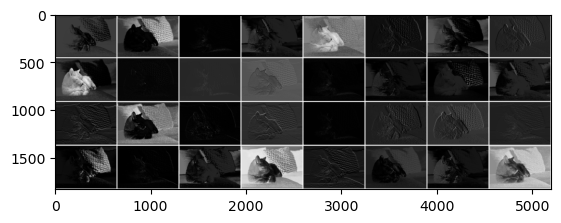

In [235]:
plt.imshow(img, cmap='gray')

In [46]:
tup1 = (0,2,3)
tup2 = (0,3,5)
dic = {}

In [47]:
dic[tup1] = 0
dic[tup2] = 2

In [50]:
tup1[0]

0

In [48]:
dic[(0,2,3)]

0

In [51]:
dic[(0,0,3)] = 5

In [49]:
for key in dic.keys():
    print(key)
    print(type(key))

(0, 2, 3)
<class 'tuple'>
(0, 3, 5)
<class 'tuple'>


# **To-Do**
- implement normalization and grid building in model
    - use tensor_collection (torch multiprocessing automatically applied) --> automatic shared memory, call detach() before
    - detach() delivers no performance gain --> ***should be called at the beginning***
    - tensors stay on GPU
- resizing and whole grid building in NumPy subprocesses:
    - get dictionary
    - cast to CPU and NumPy
    - start calculation with transformation float --> np.uint8
    - grid building
- build summary grid to for imshow
- maybe use shared array for MP and imshow process

In [1]:
import YoloDemonstration as yld

In [19]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import cv2
import torch
%matplotlib inline

In [2]:
import torch

In [3]:
torch.cuda.empty_cache()

In [4]:
#model, device = yld.load_model('yolov7.pt', device_type='cpu')
model, device = yld.load_model('yolov7.pt', device_type='gpu')

Set device type to CUDA and building for GPU
Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
Model set to FP16


C:\Users\flori\anaconda3\envs\CNN_Vis\lib\site-packages\torch\nn\modules\module.py:675: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at C:\cb\pytorch_1000000000000\work\build\aten\src\ATen/core/TensorBody.h:485.)
  if param.grad is not None:


ret = yld.prediction('input/cat.jpg', model, device, save_img=False)

In [6]:
ret = yld.prediction_wo_mp('input/cat.jpg', model, device, save_img=False)

Interference Time: 61.01346015930176 ms
Time for image post-processing: 2.0008087158203125 ms
Time for interference & image post-processing: 63.01426887512207 ms


In [7]:
ret

True

In [13]:
tensor_collection = model.tensor_collection

In [31]:
lay1 = tensor_collection[(1,64,64)]
lay2 = tensor_collection[(0,32,32)]

In [33]:
lay2

tensor([[255., 255., 255.,  ..., 255., 255., 255.],
        [255., 255., 255.,  ..., 255., 255., 255.],
        [255., 255., 255.,  ..., 255., 255., 255.],
        ...,
        [255., 255., 255.,  ..., 255., 255., 255.],
        [255., 255., 255.,  ..., 255., 255., 255.],
        [255., 255., 255.,  ..., 255., 255., 255.]], device='cuda:0', dtype=torch.float16)

In [26]:
lay1.device

device(type='cuda', index=0)

In [37]:
lay1_img = lay1.cpu().numpy()

In [38]:
lay1_img = lay1_img.astype(np.uint8)

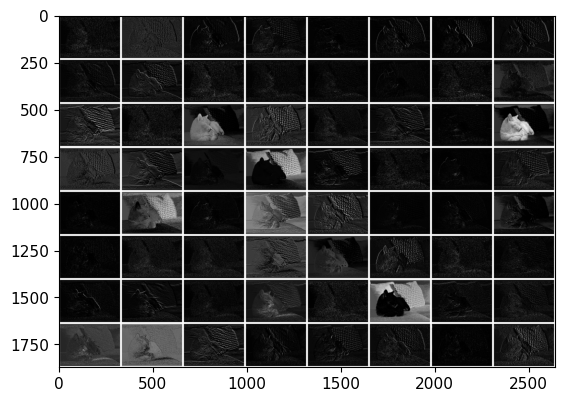

In [39]:
plt.imshow(lay1_img, cmap='gray')

In [ ]:
model()

In [3]:
t1 = load_pickle('tensor_collection_test_0.pkl')

Object loaded


In [6]:
t1 = t1[(0,32,32)]

In [10]:
t1.min()

tensor(0., device='cuda:0', dtype=torch.float16)